In [1]:
%load_ext autoreload
%autoreload 2

In [165]:
import numpy as np
import scipy
import sys
import pdb
import matplotlib.pyplot as plt
from glob import glob
import pickle
from pyuoi.linear_model.var import VAR
from tqdm import tqdm
import pandas as pd
from neurosim.models.var import VAR as VARss
from neurosim.models.var import form_companion
from copy import deepcopy
from dstableFGM import dstable_descent

In [3]:
sys.path.append('../..')
from loaders import load_sabes
from subspaces import estimate_autocorrelation
from utils import apply_df_filters

#### plots to include for 4/6:
#### (1) Pseudospectra/Polar Decomposition, (2) CV selection (joint vs marginal when applicable), (3) LQGCA subspace angles

### Fitting (Sabes)

In [6]:
data_files = glob('/mnt/Secondary/data/sabes/*.mat')

In [7]:
from sklearn.model_selection import KFold

In [81]:
# Consolidate
indy_fits = glob('/mnt/Secondary/data/indy_cv_var/indy_cv_var_*.dat')

In [97]:
rl = []
for file_ in indy_fits:
    with open(file_, 'rb') as f:
        args = pickle.load(f)
        coef = pickle.load(f)
    rd = {}
    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in value.items():
                rd[key_] = value_
        else:
            rd[key] = value
    
    rd['coef'] = coef
    rl.append(rd)

In [98]:
indy_df = pd.DataFrame(rl)

In [99]:
indy_df.keys()

Index(['data_file', 'loader', 'bin_width', 'filter_fn', 'filter_kwargs',
       'boxcox', 'spike_threshold', 'region', 'estimator', 'self_regress',
       'order', 'estimation_score', 'fold_idx', 'distributed_save',
       'data_path', 'results_file', 'coef'],
      dtype='object')

In [105]:
# Estimate autocorrelations in order to select model order
data_files = np.unique(indy_df['data_file'].values)
loader_args = {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'}

etrain = np.zeros((data_files.size, 5, 5, 5))
etest = np.zeros((data_files.size, 5, 5, 5))

for i, data_file in enumerate(data_files):
    dat = load_sabes(data_file, **loader_args)
    y = np.squeeze(dat['spike_rates'])
    fold_idx = 0
    for j, (train_idxs, test_idxs) in enumerate(KFold(5).split(y)):
        ccm_train = estimate_autocorrelation(y[train_idxs], 5)
        ccm_test = estimate_autocorrelation(y[test_idxs], 5)
        
        for k, var_order in enumerate([1, 2, 3, 4, 5]):
            df_ = apply_df_filters(indy_df, data_file=data_file, fold_idx=fold_idx, order=var_order)
            assert(df_.shape[0] == 1)
            varss = VARss(df_.iloc[0]['coef'])
            etrain[i, j, k] = [np.linalg.norm(ccm_train[idx] - varss.autocorrelation(5)[idx]) for idx in range(5)]
            etest[i, j, k] = [np.linalg.norm(ccm_test[idx] - varss.autocorrelation(5)[idx]) for idx in range(5)]

        fold_idx += 1

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.38s/it]
../../cov_estimation.py:142: RuntimeWarning: invalid value encountered in double_scalars
  ccm_sample_normalized[k, i, j] /= np.sqrt(ccm_sample[0, i, i] * ccm_sample[0, j, j])


Processing spikes


100%|██████████| 1/1 [00:22<00:00, 22.88s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


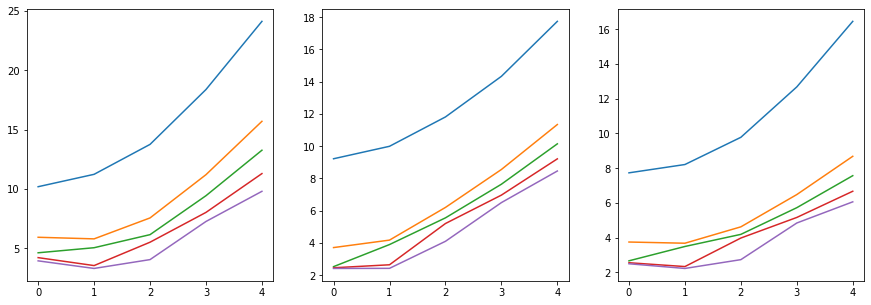

In [106]:
# Plot for each data file the average across var order
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(np.mean(etest[0, ...], axis=0))
ax[1].plot(np.mean(etest[1, ...], axis=0))
ax[2].plot(np.mean(etest[2, ...], axis=0))

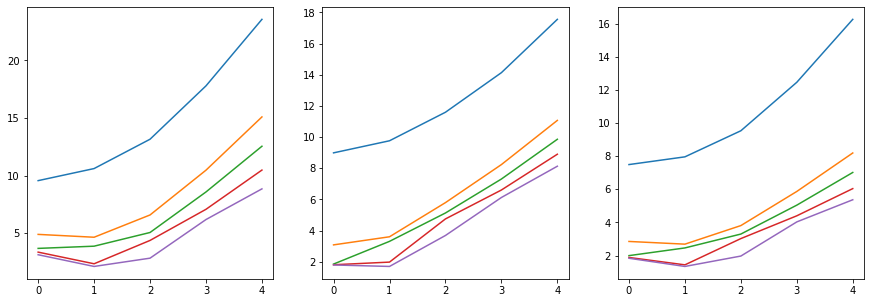

In [108]:
# Plot for each data file the average across var order
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(np.mean(etrain[0, ...], axis=0))
ax[1].plot(np.mean(etrain[1, ...], axis=0))
ax[2].plot(np.mean(etrain[2, ...], axis=0))

In [109]:
np.argmin(np.sum(etest[0, :, -1, :], axis=1))

2

In [113]:
np.argmin(np.sum(etest[2, :, -1, :], axis=1))

2

In [124]:
# Setup pseuospectra calculation overnight in separate notebook

In [ ]:
# Pseudospectra calculation
levels=[10**k for k in range(-5, 1)]
epsilons = levels
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]

mesh = []
for i, data_file in enumerate(data_files):
    X = []
    Y = []
    Z = []
    for epsilon in padepsilons:
        paths = pseudo_normal.contour_paths(epsilon)
        for path in paths:
            X += list(np.real(path.vertices[:-1]))
            Y += list(np.imag(path.vertices[:-1]))
            Z += [epsilon] * (len(path.vertices) - 1)

tc = ax[1].tricontour(X, Y, Z, levels=epsilons,  colors=[cmaphelper.get_rgb(np.log(l)) for l in levels])
for i in range(len(levels)):
    tc.collections[i].set_label(np.log10(levels[i]))

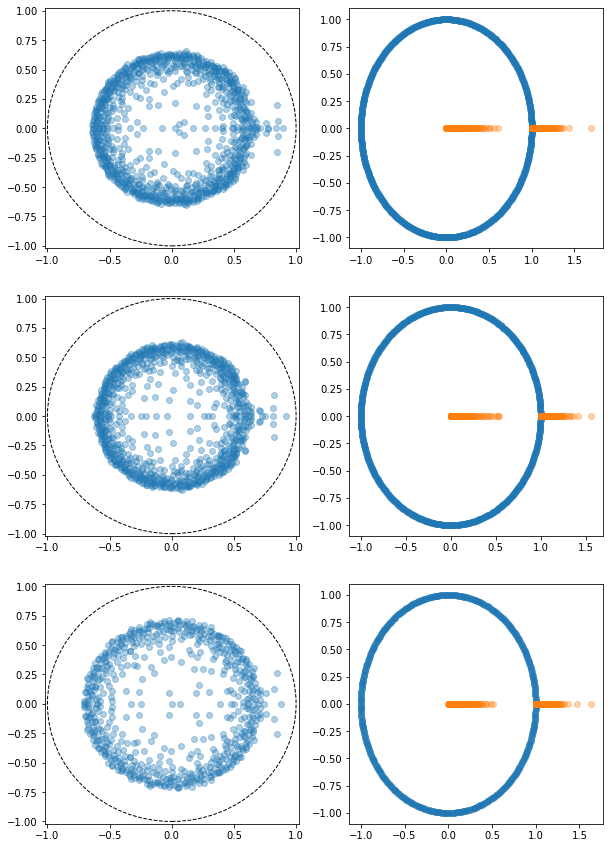

In [123]:
# Plot the spectra for the VAR(5) models, as well as their polar decomposition
cmaphelper = MplColorHelper('winter', np.log(levels[0]), 10 * np.log(levels[-1]))

# Eventually need to refit on the whole dataset
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
best_folds = [2, 4, 2]
for i, data_file in enumerate(data_files):
    df_ = apply_df_filters(indy_df, data_file=data_file, fold_idx = best_folds[i], order=5)
    A = form_companion(df_.iloc[0]['coef'])
    eig, _ = np.linalg.eig(A)
    circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
    ax[i, 0].scatter(np.real(eig), np.imag(eig), alpha=0.35)
    ax[i, 0].add_patch(circle1)
    ax[i, 0].set_xlim([-1.02, 1.02])
    ax[i, 0].set_ylim([-1.02, 1.02])

    U, P = scipy.linalg.polar(A)
    eig1, _ = np.linalg.eig(U)
    eig2, _ = np.linalg.eig(P)
    
    ax[i, 1].scatter(np.real(eig1), np.imag(eig1), alpha=0.35)
    ax[i, 1].scatter(np.real(eig2), np.imag(eig2), alpha=0.35)

In [ ]:
# Perhaps an alternative: Plot "gain" and "phase" imparted to each right singular vector. 

In [59]:
# Create a dof lookup table for sabes. This should be structured as a dataframe with keys for loader args and data file.
sabes_data_files = glob('/mnt/Secnondary/data/sabes/*.mat')
dof_list = []
loader_args = [{'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'},
               {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'},
               {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'both'}]

for data_file in tqdm(data_files):
    for loader_arg in loader_args:
        dat = load_sabes(data_file, **loader_arg)
        dof_dict = {}
        dof_dict['data_file'] = data_file
        dof_dict['dof'] = dat['spike_rates'].shape[-1]
        for key, val in loader_arg.items():
            dof_dict[key] = val
        dof_list.append(dof_dict)

  0%|          | 0/38 [00:00<?, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


Processing spikes


  3%|▎         | 1/38 [00:09<05:53,  9.56s/it]

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.23s/it]


Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.31s/it]


Processing spikes


  5%|▌         | 2/38 [01:15<25:40, 42.78s/it]

Processing spikes


100%|██████████| 1/1 [00:22<00:00, 22.46s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31300.78it/s]


Processing spikes


  8%|▊         | 3/38 [02:01<25:44, 44.12s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 39199.10it/s]


Processing spikes


 11%|█         | 4/38 [02:11<17:20, 30.59s/it]

Processing spikes


100%|██████████| 1/1 [00:31<00:00, 31.28s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 32513.98it/s]


Processing spikes


 13%|█▎        | 5/38 [03:14<23:17, 42.34s/it]

Processing spikes


100%|██████████| 1/1 [00:13<00:00, 13.57s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 29959.31it/s]


Processing spikes


 16%|█▌        | 6/38 [03:42<19:55, 37.37s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


Processing spikes


 18%|█▊        | 7/38 [03:49<14:15, 27.59s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]


Processing spikes


 21%|██        | 8/38 [03:56<10:31, 21.05s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 26051.58it/s]


Processing spikes


 24%|██▎       | 9/38 [04:05<08:21, 17.28s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]


Processing spikes


 26%|██▋       | 10/38 [04:13<06:42, 14.38s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 30615.36it/s]


Processing spikes


 29%|██▉       | 11/38 [04:20<05:30, 12.24s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


Processing spikes


 32%|███▏      | 12/38 [04:30<04:58, 11.48s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 33026.02it/s]


Processing spikes


 34%|███▍      | 13/38 [04:40<04:32, 10.90s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 28926.23it/s]


Processing spikes


 37%|███▋      | 14/38 [04:53<04:36, 11.54s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


Processing spikes


 39%|███▉      | 15/38 [05:03<04:15, 11.09s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]


Processing spikes


 42%|████▏     | 16/38 [05:13<03:57, 10.80s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


Processing spikes


 45%|████▍     | 17/38 [05:22<03:38, 10.39s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


Processing spikes


 47%|████▋     | 18/38 [05:33<03:27, 10.35s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


Processing spikes


 50%|█████     | 19/38 [05:43<03:14, 10.24s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.46s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


Processing spikes


 53%|█████▎    | 20/38 [05:54<03:09, 10.55s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]


Processing spikes


 55%|█████▌    | 21/38 [06:08<03:18, 11.65s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]


Processing spikes


 58%|█████▊    | 22/38 [06:17<02:52, 10.80s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.24s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 27776.85it/s]


Processing spikes


 61%|██████    | 23/38 [06:28<02:42, 10.80s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31300.78it/s]


Processing spikes


 63%|██████▎   | 24/38 [06:39<02:32, 10.88s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]


Processing spikes


 66%|██████▌   | 25/38 [06:50<02:24, 11.11s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34952.53it/s]


Processing spikes


 68%|██████▊   | 26/38 [07:02<02:14, 11.18s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]


Processing spikes


 71%|███████   | 27/38 [07:16<02:12, 12.06s/it]

Processing spikes


100%|██████████| 1/1 [00:07<00:00,  7.59s/it]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]


Processing spikes


 74%|███████▎  | 28/38 [07:31<02:11, 13.14s/it]

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.58s/it]


Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.44s/it]


Processing spikes


 76%|███████▋  | 29/38 [08:38<04:22, 29.19s/it]

Processing spikes


100%|██████████| 1/1 [00:22<00:00, 22.50s/it]


Processing spikes


100%|██████████| 1/1 [00:22<00:00, 22.90s/it]


Processing spikes


 79%|███████▉  | 30/38 [10:10<06:23, 47.99s/it]

Processing spikes


100%|██████████| 1/1 [00:30<00:00, 30.22s/it]


Processing spikes


100%|██████████| 1/1 [00:30<00:00, 30.15s/it]


Processing spikes


 82%|████████▏ | 31/38 [12:11<08:10, 70.03s/it]

Processing spikes


100%|██████████| 1/1 [00:10<00:00, 10.42s/it]


Processing spikes


100%|██████████| 1/1 [00:10<00:00, 10.44s/it]


Processing spikes


 84%|████████▍ | 32/38 [12:54<06:10, 61.77s/it]

Processing spikes


100%|██████████| 1/1 [00:24<00:00, 24.96s/it]


Processing spikes


100%|██████████| 1/1 [00:25<00:00, 25.03s/it]


Processing spikes


 87%|████████▋ | 33/38 [14:35<06:07, 73.52s/it]

Processing spikes


100%|██████████| 1/1 [00:17<00:00, 17.13s/it]


Processing spikes


100%|██████████| 1/1 [00:17<00:00, 17.18s/it]


Processing spikes


 89%|████████▉ | 34/38 [15:45<04:49, 72.38s/it]

Processing spikes


100%|██████████| 1/1 [00:18<00:00, 18.75s/it]


Processing spikes


100%|██████████| 1/1 [00:18<00:00, 18.98s/it]


Processing spikes


 92%|█████████▏| 35/38 [17:00<03:40, 73.40s/it]

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.40s/it]


Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.41s/it]


Processing spikes


 95%|█████████▍| 36/38 [18:06<02:22, 71.20s/it]

Processing spikes


100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


Processing spikes


100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


Processing spikes


 97%|█████████▋| 37/38 [18:50<01:02, 62.90s/it]

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.68s/it]


Processing spikes


100%|██████████| 1/1 [00:21<00:00, 21.07s/it]


Processing spikes


100%|██████████| 38/38 [20:14<00:00, 31.97s/it]


### Loco

In [154]:
loco_files = glob('/mnt/Secondary/data/loco_var_ols/loco_var_ols_*.dat')
argfiles = glob('/mnt/Secondary/data/loco_var_ols/arg*.dat')

In [153]:
file_

'/mnt/Secondary/data/loco_var_ols/loco_var_ols_297.dat'

In [159]:
rl = []
for file_ in loco_files:
    try:
        with open(file_, 'rb') as f:
            args = pickle.load(f)
            coef = pickle.load(f)
    except:
        with open(file_, 'rb') as f:
            coef = pickle.load(f)

        argno = file_.split('_')[-1].split('.dat')[0]
        argfile = '/'.join(file_.split('/')[:-1]) + '/arg%s.dat' % argno
        with open(argfile, 'rb') as f:
            args = pickle.load(f)

    rd = {}
    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in value.items():
                rd[key_] = value_
        else:
            rd[key] = value
    
    rd['coef'] = coef
    rl.append(rd)

In [161]:
with open('loco_df.dat', 'wb') as f:
    f.write(pickle.dumps(rl))

In [162]:
loco_df = pd.DataFrame(rl)

In [178]:
etrainM1 = np.zeros((len(data_files), 5, 5, 5))
etestM1 = np.zeros((len(data_files), 5, 5, 5))

etrainS1 = np.zeros((len(data_files), 5, 5, 5))
etestS1 = np.zeros((len(data_files), 5, 5, 5))

etrainjoint = np.zeros((len(data_files), 5, 5, 5))
etestjoint = np.zeros((len(data_files), 5, 5, 5))

etrainjointM1 = np.zeros((len(data_files), 5, 5, 5))
etestjointM1 = np.zeros((len(data_files), 5, 5, 5))

etrainjointS1 = np.zeros((len(data_files), 5, 5, 5))
etestjointS1 = np.zeros((len(data_files), 5, 5, 5))

for i, data_file in enumerate(data_files):
    dat = load_peanut(data_file, **loader_arg)
    tmp = deepcopy(loader_arg)
    tmp['region'] = 'HPc'
    datHPc = load_peanut(data_file, **tmp)
    HPc_size = datHPc['spike_rates'].shape[-1]

    y = np.squeeze(dat['spike_rates'])
    fold_idx = 0
    for j, (train_idxs, test_idxs) in enumerate(KFold(5).split(y)):
        ccm_train = estimate_autocorrelation(y[train_idxs], 5)
        ccm_test = estimate_autocorrelation(y[test_idxs], 5)

        ccm_train_HPc = [c[0:HPc_size, 0:HPc_size] for c in ccm_train]
        ccm_test_HPc = [c[0:HPc_size, 0:HPc_size] for c in ccm_test]

        ccm_train_OFC = [c[HPc_size:, HPc_size:] for c in ccm_train]
        ccm_test_OFC = [c[HPc_size:, HPc_size:] for c in ccm_test]

        for k, var_order in enumerate([1, 2, 3, 4, 5]):
            df_ = apply_df_filters(peanut_df, epoch=loader_arg['epoch'], fold_idx=fold_idx, order=var_order, region='both')
            try:
                assert(df_.shape[0] == 1)
            except:
                print('Missing stuff!')
                etrainjoint[i, j, k] = np.nan
                etestjoint[i, j, k] = np.nan
                etrainjointHPc[i, j, k] = np.nan
                etestjointHPc[i, j, k] = np.nan
                etrainjointOFC[i, j, k] = np.nan
                etestjointOFC[i, j, k] = np.nan
                continue
                
            varss = VARss(df_.iloc[0]['coef'])
            
            varccm = varss.autocorrelation(5)
                       
            etrainjoint[i, j, k] = [np.linalg.norm(ccm_train[idx] - varccm[idx]) for idx in range(5)]
            etestjoint[i, j, k] = [np.linalg.norm(ccm_test[idx] - varccm[idx]) for idx in range(5)]

            etrainjointHPc[i, j, k] = [np.linalg.norm(ccm_train_HPc[idx] - varccm[idx][0:HPc_size, 0:HPc_size]) for idx in range(5)]
            etestjointHPc[i, j, k] = [np.linalg.norm(ccm_test_HPc[idx] - varccm[idx][0:HPc_size, 0:HPc_size]) for idx in range(5)]

            etrainjointOFC[i, j, k] = [np.linalg.norm(ccm_train_OFC[idx] - varccm[idx][HPc_size:, HPc_size:]) for idx in range(5)]
            etestjointOFC[i, j, k] = [np.linalg.norm(ccm_test_OFC[idx] - varccm[idx][HPc_size:, HPc_size:]) for idx in range(5)]


        fold_idx += 1   

FileNotFoundError: [Errno 2] No such file or directory: '/global/cscratch1/sd/akumar25/sabes/indy_20160426_01.mat'

### Fitting (peanut)

In [138]:
from loaders import load_peanut

In [180]:
#data_file = '/home/akumar/nse/neural_control/data/data_dict_peanut_day14.obj'
data_file = '/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj'

In [64]:
# Create a dof lookup table for sabes. This should be structured as a dataframe with keys for loader args and data file.
data_file = '/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj'
dof_list = []
loader_args = [{'bin_width':25, 'epoch': epoch, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':r}
               for epoch in np.arange(2, 18, 2) for r in ['HPc', 'OFC', 'both']]
for loader_arg in loader_args:
    dat = load_peanut(data_file, **loader_arg)
    dof_dict = {}
    dof_dict['data_file'] = data_file
    dof_dict['dof'] = dat['spike_rates'].shape[-1]
    for key, val in loader_arg.items():
        dof_dict[key] = val
    dof_list.append(dof_dict)


In [70]:
dof_df = pd.DataFrame(dof_list)

In [74]:
with open('/mnt/Secondary/data/peanut/dof_list.dat', 'wb') as f:
    f.write(pickle.dumps(dof_list))

In [166]:
peanut_fits = glob('/mnt/Secondary/data/peanut_cv_var/peanut_cv_var*.dat')

In [169]:
rl = []
for file_ in peanut_fits:
    try:
        with open(file_, 'rb') as f:
            args = pickle.load(f)
            coef = pickle.load(f)
    except:
        with open(file_, 'rb') as f:
            coef = pickle.load(f)

        argno = file_.split('_')[-1].split('.dat')[0]
        argfile = '/'.join(file_.split('/')[:-1]) + '/arg%s.dat' % argno
        with open(argfile, 'rb') as f:
            args = pickle.load(f)
    rd = {}
    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in value.items():
                rd[key_] = value_
        else:
            rd[key] = value
    
    rd['coef'] = coef
    rl.append(rd)

In [140]:
# with open('peanut_df.dat', 'wb') as f:
#     f.write(pickle.dumps(rl))

with open('peanut_df.dat', 'rb') as f:
    peanut_df = pickle.load(f)

In [171]:
peanut_df = pd.DataFrame(rl)

In [185]:
# PFC only
loader_args = [{'bin_width':25, 'epoch': epoch, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100}
               for epoch in np.arange(2, 18, 2)]

etrainHPc = np.zeros((len(loader_args), 5, 5, 5))
etestHPc = np.zeros((len(loader_args), 5, 5, 5))

etrainOFC = np.zeros((len(loader_args), 5, 5, 5))
etestOFC = np.zeros((len(loader_args), 5, 5, 5))

etrainjoint = np.zeros((len(loader_args), 5, 5, 5))
etestjoint = np.zeros((len(loader_args), 5, 5, 5))

etrainjointHPc = np.zeros((len(loader_args), 5, 5, 5))
etestjointHPc = np.zeros((len(loader_args), 5, 5, 5))

etrainjointOFC = np.zeros((len(loader_args), 5, 5, 5))
etestjointOFC = np.zeros((len(loader_args), 5, 5, 5))

for i, loader_arg in tqdm(enumerate(loader_args)):
    dat = load_peanut(data_file, **loader_arg, region='both')
    tmp = deepcopy(loader_arg)
    tmp['region'] = 'HPc'
    datHPc = load_peanut(data_file, **tmp)
    HPc_size = datHPc['spike_rates'].shape[-1]
    y = np.squeeze(dat['spike_rates'])
    fold_idx = 0
    for j, (train_idxs, test_idxs) in enumerate(KFold(5).split(y)):
        ccm_train = estimate_autocorrelation(y[train_idxs], 5)
        ccm_test = estimate_autocorrelation(y[test_idxs], 5)

        ccm_train_HPc = [c[0:HPc_size, 0:HPc_size] for c in ccm_train]
        ccm_test_HPc = [c[0:HPc_size, 0:HPc_size] for c in ccm_test]

        ccm_train_OFC = [c[HPc_size:, HPc_size:] for c in ccm_train]
        ccm_test_OFC = [c[HPc_size:, HPc_size:] for c in ccm_test]

        for k, var_order in enumerate([1, 2, 3, 4, 5]):
            df_hpc = apply_df_filters(peanut_df, epoch=loader_arg['epoch'], fold_idx=fold_idx, order=var_order, region='HPc')
            df_ofc = apply_df_filters(peanut_df, epoch=loader_arg['epoch'], fold_idx=fold_idx, order=var_order, region='OFC')
            df_both = apply_df_filters(peanut_df, epoch=loader_arg['epoch'], fold_idx=fold_idx, order=var_order, region='both')

            assert(df_hpc.shape[0] == 1)
            assert(df_ofc.shape[0] == 1)
            assert(df_both.shape[0] == 1)

            var_hpc = VARss(df_hpc.iloc[0]['coef'])            
            var_ofc = VARss(df_ofc.iloc[0]['coef'])            
            var_both = VARss(df_both.iloc[0]['coef'])            

            # Stability correction
            if max(np.abs(np.linalg.eigvals(var_hpc.A))) > 0.999:
                print('Stability correcting HPC')
                try:
                    A = dstable_descent(var_hpc.A, init='random', maxiter=200)
                    var_hpc.A = A
                except:
                    pass
            if max(np.abs(np.linalg.eigvals(var_ofc.A))) > 0.999:
                print('Stability correcting OFC')
                try:
                    A = dstable_descent(var_ofc.A, init='random', maxiter=200)
                    var_ofc.A = A
                except:
                    pass
            if max(np.abs(np.linalg.eigvals(var_both.A))) > 0.999:
                print('Stability correcting joint')
                try:
                    A = dstable_descent(var_both.A, init='random', maxiter=200)
                    var_both.A = A
                except:
                    pass

            hpcccm = var_hpc.autocorrelation(5)
            ofcccm = var_ofc.autocorrelation(5)
            jointccm = var_both.autocorrelation(5)

            etrainHPc[i, j, k] = [np.linalg.norm(ccm_train_HPc[idx] - hpcccm[idx]) for idx in range(5)]
            etestHPc[i, j, k] = [np.linalg.norm(ccm_test_HPc[idx] - hpcccm[idx]) for idx in range(5)]
            
            etrainOFC[i, j, k] = [np.linalg.norm(ccm_train_OFC[idx] - ofcccm[idx]) for idx in range(5)]
            etestOFC[i, j, k] = [np.linalg.norm(ccm_test_OFC[idx] - ofcccm[idx]) for idx in range(5)]
            
            etrainjoint[i, j, k] = [np.linalg.norm(ccm_train[idx] - jointccm[idx]) for idx in range(5)]
            etestjoint[i, j, k] = [np.linalg.norm(ccm_test[idx] - jointccm[idx]) for idx in range(5)]

            etrainjointHPc[i, j, k] = [np.linalg.norm(ccm_train_HPc[idx] - jointccm[idx][0:HPc_size, 0:HPc_size]) for idx in range(5)]
            etestjointHPc[i, j, k] = [np.linalg.norm(ccm_test_HPc[idx] - jointccm[idx][0:HPc_size, 0:HPc_size]) for idx in range(5)]

            etrainjointOFC[i, j, k] = [np.linalg.norm(ccm_train_OFC[idx] - jointccm[idx][HPc_size:, HPc_size:]) for idx in range(5)]
            etestjointOFC[i, j, k] = [np.linalg.norm(ccm_test_OFC[idx] - jointccm[idx][HPc_size:, HPc_size:]) for idx in range(5)]

        fold_idx += 1   

0it [00:00, ?it/s]../../cov_estimation.py:142: RuntimeWarning: invalid value encountered in double_scalars
  ccm_sample_normalized[k, i, j] /= np.sqrt(ccm_sample[0, i, i] * ccm_sample[0, j, j])


Stability correcting HPC
61.815597391335196
59.39723908784945
58.98973903394632
57.93390802802627
57.37711327264375
57.2255430021228
56.63000899721371
56.384770434867015
55.49672146191395
55.079841308577876
53.97532487559012
53.88423512549516
52.6110469297551
52.395430950497826
51.50212029712653
51.32931247023568
50.07920124905268
49.93451829934976
49.15656530384091
48.75594434317389
47.434901001356316
47.11691324956385
46.232984673655395
45.946044074568114
45.914162397396815
45.83616816947326
44.52057889531423
43.465933545241015
42.38049642599621
41.93706708314112
38.78418204977793
37.480688590945434
37.218948004647984
36.649374961285375
36.6245355102082
36.29833263086601
36.00113112343674
33.39740617318126
33.286701981865825
33.230721216249165
32.57935701588076
30.848111127067924
30.76916528860251
30.608280394382934
29.7444128869859
28.82060250415948
28.777386333282514
28.362853666865323
27.466202583508057
26.87214002920429
26.628233732626626
26.30133924363373
25.97878328784663
25.11

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/scipy/linalg/_solvers.py:196: RuntimeWarning: Input "a" has an eigenvalue pair whose sum is very close to or exactly zero. The solution is obtained via perturbing the coefficients.
  RuntimeWarning)


Stability correcting HPC
1.7398523085936694e+22
Descent failed
Stability correcting OFC
81.06887895292475
81.00313349384884
80.94666557787721
80.91909614065405
80.9007364087012
80.87333221573186
80.85154761408474
80.83900323895217
80.82999090188802
80.81375097533423
80.79694176882848
80.79128957183843
80.78706720209799
80.77135436530129
80.754577655089
80.74914930262186
80.7425260713135
80.72773065017076
80.71439075532359
80.70668784092582
80.69845112751769
80.69734870219517
80.68158973029537
80.67421755784025
80.6658635966527
80.6620938291372
80.65961949506406
80.65023796466261
80.6383640844572
80.63479444226552
80.62939141832383
80.61730759741918
80.61717436143492
80.61276111502418
80.60256555439611
80.58692104897798
80.58176088741494
80.57381574959814
80.56485323915177
80.55959079977497
80.55372155716258
80.5449842889083
80.54202478490386
80.53758326184692
80.52970021497792
80.5181331174369
80.51332741875702
80.5064405644912
80.49830886030863
80.49381216182381
80.48877878110179
80.4

In [148]:
# Peanut requires stability regularization

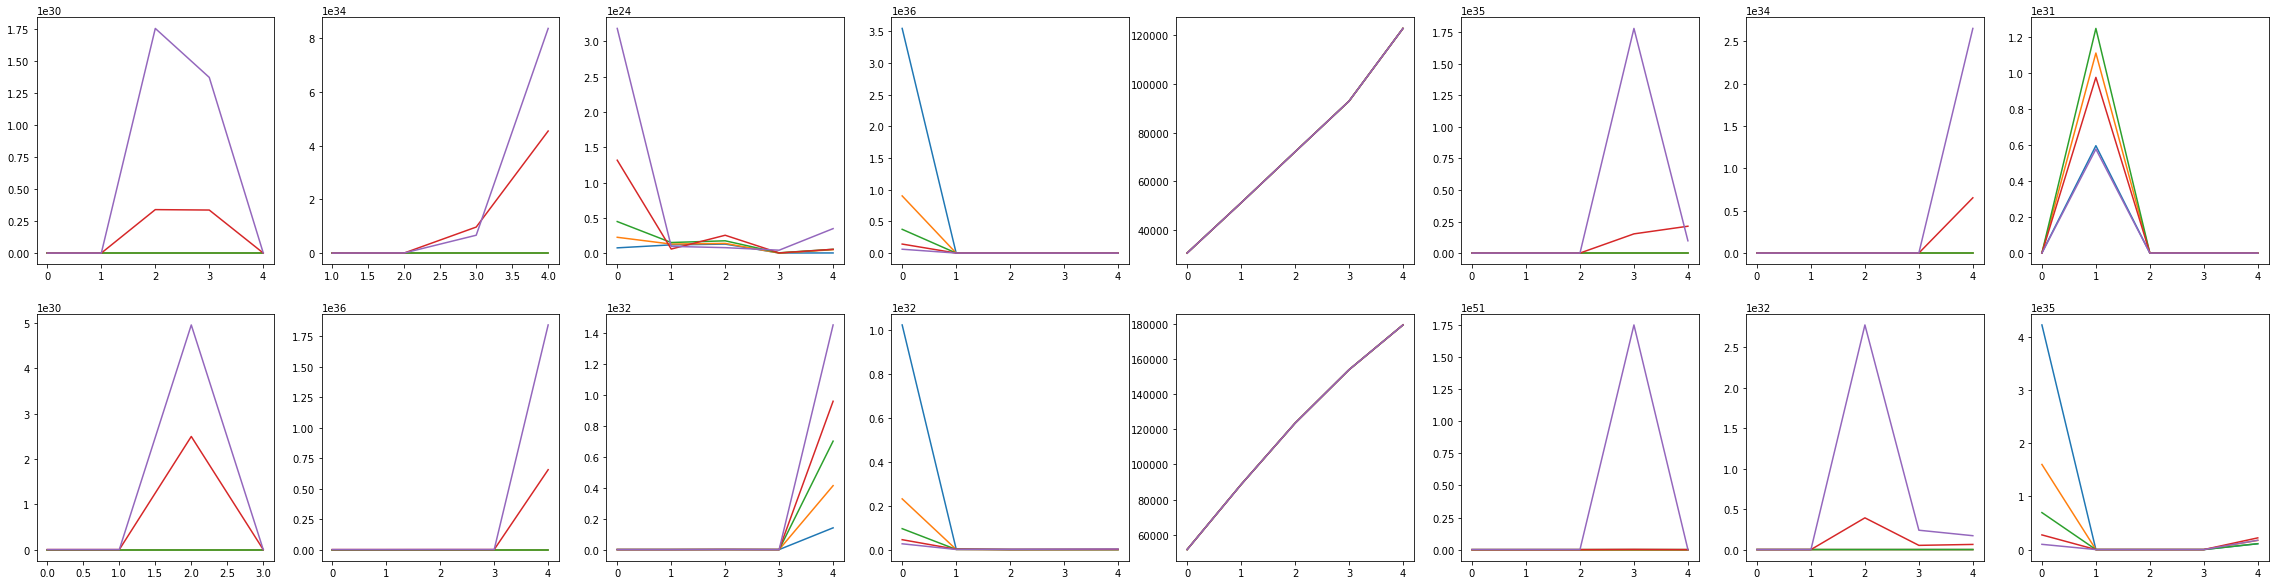

In [147]:
# Plot
# Plot for each data file the average across var order
fig, ax = plt.subplots(2, 8, figsize=(40, 10))
for i in range(etestHPc.shape[0]):
    ax[0, i].plot(np.mean(etestHPc[i, ...], axis=0))
    ax[1, i].plot(np.mean(etestjointHPc[i, ...], axis=0))

### Fitting (CV)

In [7]:
import pickle
import h5py
from sklearn.model_selection import KFold

In [8]:
f = h5py.File('/home/akumar/nse/neural_control/data/EC2_hg.h5', 'r')

In [9]:
X = np.squeeze(f['X'])
y = np.array(f['y'])

In [10]:
# Remove 'thee'
theeless = np.where(y != b'thee')[0]
X = X[theeless, ...]
y = y[theeless]

In [11]:
X.shape

(2566, 258, 86)

In [57]:
cv_result_list = []
fold_idx = 0 

# Cross-validated marginal models
for train_idxs, test_idxs in KFold(5).split(X):

    ccm_train = estimate_autocorrelation(X[train_idxs], 5)
    ccm_test = estimate_autocorrelation(X[test_idxs], 5)

    for var_order in [1, 2, 3, 4, 5]:
        
        results = {}
        results['fold_idx'] = fold_idx
        results['var_order'] = var_order
        results['ccm_train'] = ccm_train
        results['ccm_test'] = ccm_test

        varmodel = VAR(estimator='ols', order=var_order)
        varmodel.fit(X[train_idxs])
        results['coef'] = varmodel.coef_
        cv_result_list.append(results)

    fold_idx += 1   

Rows of VAR matrix processed: 86it [01:22,  1.04it/s]
Rows of VAR matrix processed: 86it [02:50,  1.99s/it]
Rows of VAR matrix processed: 86it [05:10,  3.61s/it]
Rows of VAR matrix processed: 86it [07:24,  5.17s/it]
Rows of VAR matrix processed: 86it [09:36,  6.71s/it]
Rows of VAR matrix processed: 86it [01:21,  1.06it/s]
Rows of VAR matrix processed: 86it [02:38,  1.84s/it]
Rows of VAR matrix processed: 86it [04:52,  3.40s/it]
Rows of VAR matrix processed: 86it [07:02,  4.92s/it]
Rows of VAR matrix processed: 86it [09:43,  6.78s/it]
Rows of VAR matrix processed: 86it [01:21,  1.06it/s]
Rows of VAR matrix processed: 86it [02:42,  1.89s/it]
Rows of VAR matrix processed: 86it [04:40,  3.27s/it]
Rows of VAR matrix processed: 86it [06:51,  4.79s/it]
Rows of VAR matrix processed: 86it [09:25,  6.58s/it]
Rows of VAR matrix processed: 86it [01:20,  1.06it/s]
Rows of VAR matrix processed: 86it [02:40,  1.86s/it]
Rows of VAR matrix processed: 86it [04:39,  3.25s/it]
Rows of VAR matrix processed

In [12]:
# with open('cv_result_list.dat', 'wb') as f:
#     f.write(pickle.dumps(cv_result_list))
with open('cv_result_list.dat', 'rb') as f:
    cv_result_list = pickle.load(f)

In [13]:
cv_df = pd.DataFrame(cv_result_list)

In [14]:
etrain = np.zeros((5, 5, 5))
etest = np.zeros((5, 5, 5))

fold_idx = 0
for j, (train_idxs, test_idxs) in enumerate(KFold(5).split(X)):
    ccm_train = estimate_autocorrelation(X[train_idxs], 5)
    ccm_test = estimate_autocorrelation(X[test_idxs], 5)
    
    for k, var_order in enumerate([1, 2, 3, 4, 5]):
        df_ = apply_df_filters(cv_df, fold_idx=fold_idx, var_order=var_order)
        assert(df_.shape[0] == 1)
        varss = VARss(df_.iloc[0]['coef'])
        etrain[j, k] = [np.linalg.norm(ccm_train[idx] - varss.autocorrelation(5)[idx]) for idx in range(5)]
        etest[j, k] = [np.linalg.norm(ccm_test[idx] - varss.autocorrelation(5)[idx]) for idx in range(5)]

    fold_idx += 1

In [17]:
with open('CV_ccm_errors.dat', 'wb') as f:
    f.write(pickle.dumps(etest))
    f.write(pickle.dumps(etrain))

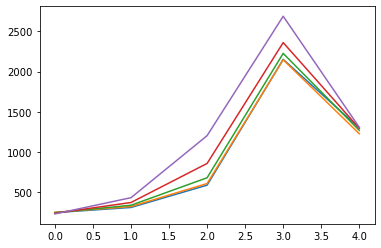

In [15]:
plt.plot(np.mean(etest, axis=0))

In [32]:
np.argmin(np.sum(etest[:, 1, :], axis=-1))

0

(-1.02, 1.02)

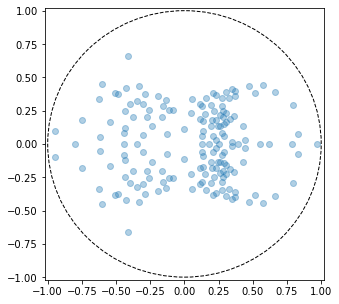

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
best_fold = 0
df_ = apply_df_filters(cv_df, fold_idx = best_fold, var_order=2)
A = form_companion(df_.iloc[0]['coef'])
eig, _ = np.linalg.eig(A)
circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax.scatter(np.real(eig), np.imag(eig), alpha=0.35)
ax.add_patch(circle1)
ax.set_xlim([-1.02, 1.02])
ax.set_ylim([-1.02, 1.02])


In [4]:
from pseudopy import NonnormalAuto, Normal

In [39]:
pseudo_normal = Normal(A)

In [42]:
pseudo = NonnormalAuto(A, 1e-5, 1)

KeyboardInterrupt: 

In [5]:
Atest = np.random.normal(size=(10, 10))

In [6]:
pseudo = NonnormalAuto(Atest, 1e-5, 1)

0.022140026092529297
0.3082287311553955


### Fitting (PVC)

In [60]:
from scipy import io

In [ ]:
# Subspace angles/Spearman correlation

### LQGCA subspace angles

In [12]:
# Should already exist for indy, extend for LOCO here
loco_files = glob('/mnt/Secondary/data/sabes/loco*')